# load and analyze dataset

In [92]:
import pandas as pd
import numpy as np
import collections
import nltk
import time

np.random.seed()

In [25]:
#load data from csv
data_path = "/Users/xyli1905/Projects/Datasets/Kaggle/QuoraToxicDetect/train.csv"
test_path = "/Users/xyli1905/Projects/Datasets/Kaggle/QuoraToxicDetect/test.csv"
data = pd.read_csv(data_path)

In [26]:
data.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [27]:
# data["target"] to np array data_label
data_label = np.array(data["target"])
#print(data_label)
dist_dic = collections.Counter(data_label)
print(" num of Label 0: %s \n num of Label 1: %s \n Toxic percentage: %s %s" \
      % (dist_dic[0], dist_dic[1], dist_dic[1]/(dist_dic[0] + dist_dic[1])*100., "%"))

 num of Label 0: 1225312 
 num of Label 1: 80810 
 Toxic percentage: 6.187017751787352 %


In [28]:
# put all text seq in data_seq for further processing
seq_num = len(data)
data_seq = list(data["question_text"])

In [29]:
# define regular expressions for preprocessing
import re

# for latex math expression
process_latex_expression = re.compile("(\[math)((\S|\s)+?)(math\])")
# for quotation
process_quotation_single = re.compile("(\s+|\,\.\?|^)(\')((\s|\S)+?)(\')")
process_quotation_double1 = re.compile("(\s+|\,\.\?|^)(\'\')((\s|\S)+?)(\'\')")
process_quotation_double2 = re.compile("(\s+|\,\.\?|^)(\")((\s|\S)+?)(\")")
process_quotation_triple = re.compile("(\s+|\,\.\?|^)(\'\'\')((\s|\S)+?)(\'\'\')")
process_quotation_special = re.compile("(\s+|\,\.\?|^)(\')((\s|\S)+?)(\")")
# for bracketed words
process_bracketed_words  = re.compile("(\s*|^)(\()((\s|\S)+?)(\))")
# for web address
process_url_http = re.compile("(http|https)((\S|\s)+?)(\s+|$)")
process_url_www = re.compile("(www)((\S|\s)+?)(\s+|$)")
# for parallel words, "/" --> "or"
process_double_parallel_words = re.compile("(\s+|^)([A-Za-z\-]+)(\/)([A-Za-z\-]+)(\s+|[\.\?\,\!]|$)")
process_triple_parallel_words = re.compile("(\s+|^)([A-Za-z\-]+)(\/)([A-Za-z\-]+)(\/)([A-Za-z\-]+)(\s+|[\.\?\,\!]|$)")
# for numbers 1231 2321.231 --> numbsymb
process_number = re.compile("(\s+|^)((\d+\.\d+)|(\d+))")

In [30]:
def RE_preprocessing(seq):
    '''
    note we use repr(" "+content[2])[1:-1] to turn the string into raw string
    '''
    # replace latex expression with standard symbol
    seq = process_latex_expression.sub("latexmathexpression", seq)

    # replace web address: http(s):... or www. with standard symbol
    seq = process_url_http.sub("webaddress ", seq)
    seq = process_url_www.sub("webaddress ", seq)
    
    # check for quotations and delete ''' ''', '' '', ' ' or " " symbols
    match = process_quotation_triple.findall(seq)
    for content in match:
        seq = process_quotation_triple.sub(repr(" "+content[2])[1:-1], seq, 1)
    
    match = process_quotation_double1.findall(seq)
    for content in match:
        seq = process_quotation_double1.sub(repr(" "+content[2])[1:-1], seq, 1)

    match = process_quotation_single.findall(seq)
    for content in match:
        seq = process_quotation_single.sub(repr(" "+content[2])[1:-1], seq, 1)
        
    match = process_quotation_double2.findall(seq)
    for content in match:
        seq = process_quotation_double2.sub(repr(" "+content[2])[1:-1], seq, 1)
        
    match = process_quotation_special.findall(seq)
    for content in match:
        seq = process_quotation_special.sub(repr(" "+content[2])[1:-1], seq, 1)
        
    # check for bracketed content and delete the brackets
    match = process_bracketed_words.findall(seq)
    for content in match:
        seq = process_bracketed_words.sub(repr(" "+content[2])[1:-1], seq, 1)

    # check parallel words, and replace "/" with " or "
    match = process_triple_parallel_words.findall(seq)
    for content in match:
        contentstr = " " + content[1] + " or " + content[3] + " or " + content[5] + " " + content[-1]
        seq = process_triple_parallel_words.sub(repr(contentstr)[1:-1], seq, 1)
    
    match = process_double_parallel_words.findall(seq)
    for content in match:
        contentstr = " " + content[1] + " or " + content[3] + " " + content[-1]
        seq = process_double_parallel_words.sub(repr(contentstr)[1:-1], seq, 1)
        
    # replace number e.g. 99 or 99.99 as "numbsymb"
    seq = process_number.sub(" numbsymb", seq)
    
    return seq

def RE_preprocessing_except(seq):
    '''
    note use this if repr(" "+content[2])[1:-1] raise an exception
    '''
    # replace latex expression with standard symbol
    seq = process_latex_expression.sub("latexmathexpression", seq)

    # replace web address: http(s):... or www. with standard symbol
    seq = process_url_http.sub("webaddress ", seq)
    seq = process_url_www.sub("webaddress ", seq)
    
    # check for quotations and delete ''' ''', '' '', ' ' or " " symbols
    match = process_quotation_triple.findall(seq)
    for content in match:
        seq = process_quotation_triple.sub(" "+content[2], seq, 1)
    
    match = process_quotation_double1.findall(seq)
    for content in match:
        seq = process_quotation_double1.sub(" "+content[2], seq, 1)

    match = process_quotation_single.findall(seq)
    for content in match:
        seq = process_quotation_single.sub(" "+content[2], seq, 1)
        
    match = process_quotation_double2.findall(seq)
    for content in match:
        seq = process_quotation_double2.sub(" "+content[2], seq, 1)
        
    match = process_quotation_special.findall(seq)
    for content in match:
        seq = process_quotation_special.sub(" "+content[2], seq, 1)
        
    # check for bracketed content and delete the brackets
    match = process_bracketed_words.findall(seq)
    for content in match:
        seq = process_bracketed_words.sub(" "+content[2], seq, 1)
        
    # check parallel words, and replace "/" with " or "
    match = process_triple_parallel_words.findall(seq)
    for content in match:
        contentstr = " " + content[1] + " or " + content[3] + " or " + content[5] + " " + content[-1]
        seq = process_triple_parallel_words.sub(contentstr, seq, 1)
    
    match = process_double_parallel_words.findall(seq)
    for content in match:
        contentstr = " " + content[1] + " or " + content[3] + " " + content[-1]
        seq = process_double_parallel_words.sub(contentstr, seq, 1)
        
    # replace number e.g. 99 or 99.99 as "numbsymb"
    seq = process_number.sub("numbsymb", seq)
    
    return seq

In [31]:
# question tokenization for training data
# delete stop word?
t1 = time.time()
data_token = []
for i in range(seq_num):
    data_seq[i] = data_seq[i].lower()
    try:
        data_seq[i] = RE_preprocessing(data_seq[i])
        data_token.append(nltk.word_tokenize(data_seq[i]))
    except:
        try:
            data_seq[i] = RE_preprocessing_except(data_seq[i])
            data_token.append(nltk.word_tokenize(data_seq[i]))
        except:
            print(i)
t2 = time.time()
print("Time for tokenizing each question is %s (s)" % (t2-t1))

Time for tokenizing each question is 165.0142102241516 (s)


In [32]:
# build vocabulary from the traning + test data
t1 = time.time()
words = []
for question in data_token:
    for word in question:
        words.append(word)
vocab = sorted(set(words))
t2 = time.time()
print("Time for getting vocabulary is %s (s)" % (t2-t1))
#print(len(context))

Time for getting vocabulary is 3.7075717449188232 (s)


In [33]:
print(len(vocab), len(data_token))

227734 1306122


In [138]:
# terms that are not defined in embedding will be mapped into a single embedding vector, e.g.
# - unrecognized symbols
# - characters in chinese & other languages
#
# NOTE the following were/will be preprocessed:
# [] money (maybe not important?)
# [] dates/time ?how?
# [] general math expression ?how?
# [x] numbers --> numbersymb (a preliminary preprocessing)
# [x] web address / url --> webaddress
# [x] latex math expressions --> latexmathexpression
# [x] single/double quotation marks
# [x] bracketed words
# [x] split words connected by "/", substitute "/" with " or " (a preliminary preprocessing)
#
vocab_len = len(vocab)
print("there are %s words in vocabulary" % vocab_len)
base = 21
start = 1000 * base
num = 1000
print(vocab[start:start + num])
# with open('vocab.txt', 'w') as f:
#     for item in vocab:
#         f.write("%s\n" % item)

there are 227734 words in vocabulary
['bambino', 'bambolim', 'bamboo', 'bamboozle', 'bamboozled', 'bamburgh', 'bamcef', 'bamdad', 'bame', 'bamec', 'bamenda', 'bamford', 'bamgkok', 'bamigo', 'bamk', 'bamm-bamm', 'bamnoli', 'bamoer', 'bams', 'bamu', 'ban', 'ban-us.com', 'bana', 'banach', 'banagalore', 'banagar', 'banaglandia', 'banaglore', 'banajiga', 'banake', 'banal', 'banalizes', 'banalore', 'banana', 'banana-shaped', 'bananacoin', 'bananagrams', 'bananan', 'bananas', 'bananatag', 'banans', 'banao', 'banapple', 'banaras', 'banarasi', 'banarasidas', 'banarjee', 'banarsi', 'banashankari', 'banasthali', 'banasthli', 'banasura', 'banat', 'banca', 'bancaire', 'bancassurance', 'banch', 'banchi', 'banco', 'bancomext', 'bancoop', 'bancor', 'bancorp', 'bancorporation', 'bancourt', 'bancroft', 'bancrofti', 'bancshares', 'band', 'band-aid', 'band-tailed', 'band2', 'banda', 'bandage', 'bandaged', 'bandages', 'bandai', 'bandaid', 'bandaids', 'bandana', 'bandanas', 'bandar', 'bandar-log', 'bandara'

In [147]:
words.count("…how")

7

## distribution of question len in preprocessed data_seq

In [96]:
import matplotlib.pyplot as plt

In [43]:
# the longest question in raw string form
maxlen = 0
for i in range(seq_num):
    tmplen = len(data_seq[i])
    if tmplen > maxlen:
        maxidx = i
        maxlen = tmplen
print("max Question len is %s, \nwhose idx is %s\n" % (maxlen, maxidx))
print(data_seq[maxidx])
print(data_token[maxidx])

max Question len is 806, 
whose idx is 522266

in star trek numbsymb why did they :

*spoilers*
*spoilers*
*spoilers*
*spoilers* numbsymb)make warping look quite a bit like an hyperspace jump numbsymb)what in the world were those bright particles as soon as they jumped. numbsymb)why in the world did they make it possible for two entities to react in warp space in separate jumps. numbsymb)why did spock get emotions for this movie. numbsymb)what was the point of hiding the enterprise underwater. numbsymb)when they were intercepted by the dark ship, how come they reached earth when they were far away from her. i don't seem to remember the scene where they warp to earth. numbsymb)how did the ship enter earth's atmosphere when it wasnt even in orbit. numbsymb)when scotty opened the door of the black ship , how come pike and khan didn't slow down?
['in', 'star', 'trek', 'numbsymb', 'why', 'did', 'they', ':', '*spoilers*', '*spoilers*', '*spoilers*', '*spoilers*', 'numbsymb', ')', 'make', 'wa

In [100]:
def max_token_length(token):
    maxl = 0
    idxl = 0
    for i in range(seq_num):
        tmplen = len(token[i])
        if tmplen > maxl:
            idxl = i
            maxl = tmplen
    return maxl, idxl

max_token_len, max_token_idx = max_token_length(data_token)
print(max_token_len, max_token_idx)

163 522266


In [103]:
#data_token[522266]

In [104]:
def count_QWords(token_list):
    len_dist = np.zeros(max_token_len, dtype = np.int)
    for i in range(seq_num):
        len_dist[len(token_list[i])-1] += 1
    
    return len_dist
token_len_dist = count_QWords(data_token)

[     6     20     81   5967  21412  41856  72121 101222 117865 119703
 113027  98633  84741  71647  60685  50685  42997  36569  31462  27180
  23468  20453  18197  16396  14598  13093  11841  10543   9280   8101
   7085   6269   5377   4642   3880   3562   3125   2829   2648   2468
   2272   2156   2004   1872   1780   1671   1462   1250   1150    936
    844    634    550    445    371    273    204    160    110     79
     54     36     24      8     12     14      2      3      3      2
      0      2      1      0      0      0      0      0      1      0
      0      0      0      0      0      0      1      0      0      0
      0      0      0      0      0      0      0      1      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

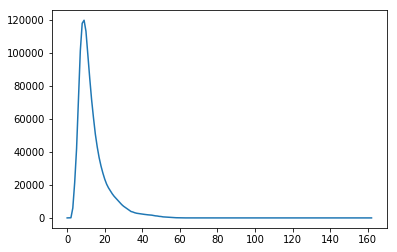

In [108]:
# distribution of number of words in data_token
plt.plot(token_len_dist)
print(token_len_dist)

## test on regular expression

In [253]:
import pprint

In [388]:
#porcess_latex_expression1 = re.compile("(\[math\])((\S|\s)+?)(\[/math\])")
test_porcess_latex_expression = re.compile("(\[math)((\S|\s)+?)(math\])")
test_process_quotation_single = re.compile("(\s+|^)(\')((\s|\S)+?)(\')")
test_process_quotation_double1 = re.compile("(\s+|^)(\'\')((\s|\S)+?)(\'\')")
test_process_quotation_double2 = re.compile("(\s+|^)(\")((\s|\S)+?)(\")")
test_process_bracketed_words  = re.compile("((\s+|\S)|^)(\()((\s|\S)+?)(\))")

In [255]:
test_seq = "when they were intercepted by the dark ship, how come they reached earth when they were far away from her. (i don't seem to remember the scene where they warp to earth)."
print(test_seq)

when they were intercepted by the dark ship, how come they reached earth when they were far away from her. (i don't seem to remember the scene where they warp to earth).


In [256]:
# test_seq = process_quotation_single.sub('',test_seq)
# test_seq = process_quotation_double1.sub(" test", test_seq)
# test_seq = process_quotation_double2.sub(" test", test_seq)
# test_seq = process_bracketed_words.sub(" test", test_seq)

# print(test_seq)

In [257]:
vv = test_process_bracketed_words.findall(test_seq)
for term in vv:
    print(term)
    test_seq = test_process_bracketed_words.sub(" " + term[3], test_seq, 1)
print(test_seq)

(' ', ' ', '(', "i don't seem to remember the scene where they warp to earth", 'h', ')')
when they were intercepted by the dark ship, how come they reached earth when they were far away from her. i don't seem to remember the scene where they warp to earth.


In [216]:
vv = test_process_quotation_single.findall(test_seq)
for term in vv:
    test_seq = test_process_quotation_single.sub(" " + term[2], test_seq, 1)
print(test_seq)

asdfasf dasfas dffasd dafsdf dd


In [491]:
test_seq = data_seq[620542]
print(test_seq)

#print(test_porcess_latex_expression.sub("latexmathexpression", test_seq))

vv = test_process_quotation_double2.findall(test_seq)
for term in vv:
    print(term)
    test_seq = test_process_quotation_double2.sub(" " + term[2], test_seq, 1)
print(test_seq)

vv = test_process_bracketed_words.findall(test_seq)
for term in vv:
    print(term)
    print(repr(" " + term[3])[1:-1])
    test_seq = test_process_bracketed_words.sub(repr(" " + term[3])[1:-1], test_seq, 1)
print(test_seq)

What is the opposite​ term for "connection​ established"​?
(' ', '"', 'connection\u200b established', 'd', '"')
What is the opposite​ term for connection​ established​?
What is the opposite​ term for connection​ established​?


In [429]:
test = "https://w3resource.com"
nltk.word_tokenize(test)

['https', ':', '//w3resource.com']

In [674]:
test = "Who are https://ant.isi.edu? https://ant.isi.edu"

In [675]:
test_porcess_url_http = re.compile("(http|https)((\S|\s)+?)(\s+|$)")
test_porcess_url_www = re.compile("(www)((\S|\s)+?)(\s+|$)")

In [676]:
test = test_porcess_url_http.sub("webaddress ", test)
test = test_porcess_url_www.sub("webaddress ", test)
print(test)

Who are webaddress webaddress 


In [670]:
test = "Why are the salaries of automobile/mechan-ical"
nltk.word_tokenize(test)
print(test)

Why are the salaries of automobile/mechan-ical


In [671]:
test_process_double_parallel_words = re.compile("(\s+|^)([A-Za-z\-]+)(\/)([A-Za-z\-]+)(\s+|[\.\?\,\!]|$)")
test_process_triple_parallel_words = re.compile("(\s+|^)([A-Za-z\-]+)(\/)([A-Za-z]+\-)(\/)([A-Za-z\-]+)(\s+|$)")

In [672]:
vv = process_bracketed_words.findall(test)
for term in vv:
    print(term)
    test = test_process_bracketed_words.sub(" " + term[2], test, 1)
print(test)

Why are the salaries of automobile/mechan-ical


In [673]:
vv = test_process_double_parallel_words.findall(test)
print(vv)

for term in vv:
    print(term)
    print(term[1],term[3],term[-1])
    test = test_process_double_parallel_words.sub(repr(" " + term[1] + " or " + term[3] + " " + term[-1])[1:-1], test, 1)
print(test)

[(' ', 'automobile', '/', 'mechan-ical', '')]
(' ', 'automobile', '/', 'mechan-ical', '')
automobile mechan-ical 
Why are the salaries of automobile or mechan-ical 


In [8]:
test = data_seq[1037]
print(test)
test_process_number = re.compile("((\d+\.\d+)|(\d+))")

Why senior employees (4-8 yr exp.) of service based company (Infy/Wipro/CTS) never motivate juniors to switch to product based company?


In [9]:
test_process_number.sub("d ", test)

'Why senior employees (d -d  yr exp.) of service based company (Infy/Wipro/CTS) never motivate juniors to switch to product based company?'

# embedding

In [89]:
# don't in the embedding?
import os
from torch.nn import Embedding

In [39]:
embedding_path = "/Users/xyli1905/Projects/embeddings/glove.6B/"

In [67]:
def loadGlove(path, name="6B", dim=50):
    glove_name = "glove.{}.{}d.txt".format(name, str(dim))
    glove_path = os.path.join(path, glove_name)
    #print(glove_path)
    #glove = pd.read_csv(glove_path, sep=" ", header=None)
    glove_file = open(glove_path, "r")
    glove = {}
    for line in glove_file.readlines():
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        glove[word] = embedding
    return glove

In [68]:
glove = loadGlove(embedding_path)

In [134]:
emb_dim = 50
latex_math_emb = np.random.normal(scale=0.6, size=(emb_dim, ))
webaddress_emb = np.random.normal(scale=0.6, size=(emb_dim, ))
numbsymb_emb   = np.random.normal(scale=0.6, size=(emb_dim, ))
unknow_word_emb = np.random.normal(scale=0.6, size=(emb_dim, ))
def get_embedding(word):
    try:
        embedding = glove[word]
    except:
        if word == "latexmathexpression":
            embedding = latex_math_emb
        elif word == "webaddress":
            embedding = webaddress_emb
        elif word == "numbsymb":
            embedding = numbsymb_emb
        else:
            print("key not included, use new value:")
            embedding = unknow_word_emb
        
    return embedding

In [141]:
word = "card"
embedding = get_embedding(word)
print(embedding)

[-0.49282   0.34231   0.93662   0.86695   0.62261   0.014615 -0.62331
  0.021383  0.25933   0.23695  -0.043837  0.65615  -0.1218    0.1839
  0.72801  -0.57085  -0.99428  -0.76187   0.044481 -0.66478   0.35339
 -1.372    -0.70328   0.34372  -0.55958  -1.5715   -0.073208 -0.62584
  0.20277  -1.1796    2.4812    0.55142   0.018541  0.2869    0.1141
  0.60408   0.55863   0.13701  -0.33045  -1.3547    1.0943    0.07671
 -0.25892   0.7989   -0.14411  -0.34701   0.31202   0.186     0.85489
  0.025597]


In [131]:
EmbeddingLayer = Embedding(vocab_len, emb_dim)